Loading data...
Loaded 36000 baseline records
Loaded 3600 adaptive records

Generating RQ2 Analysis...

Processing workload1...
Creating SLA stability coefficient plot...
Saved: RQ2_figures/sla_stability_workload1.pdf


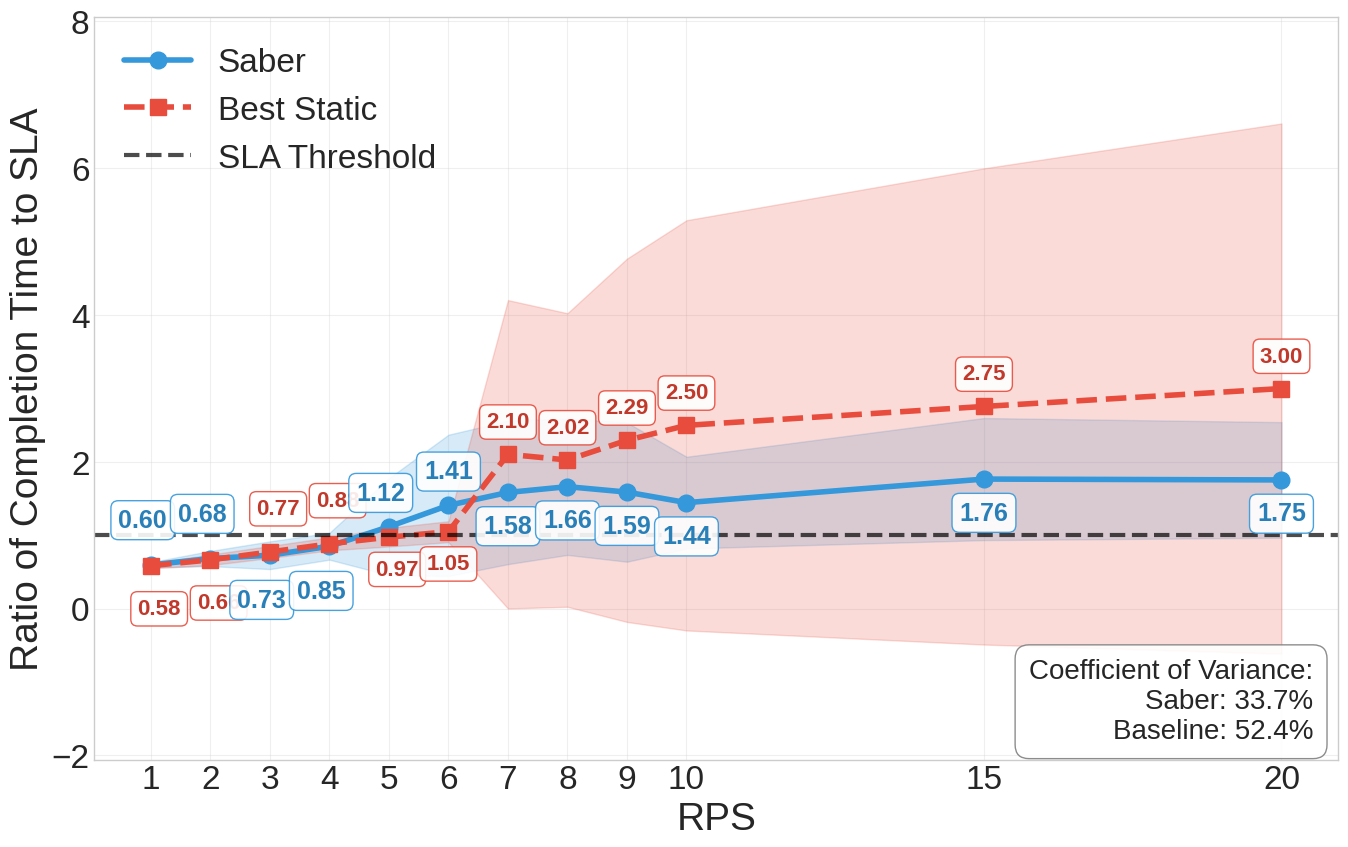

Creating goodput performance plot with annotations...
Saved: RQ2_figures/goodput_performance_workload1.pdf


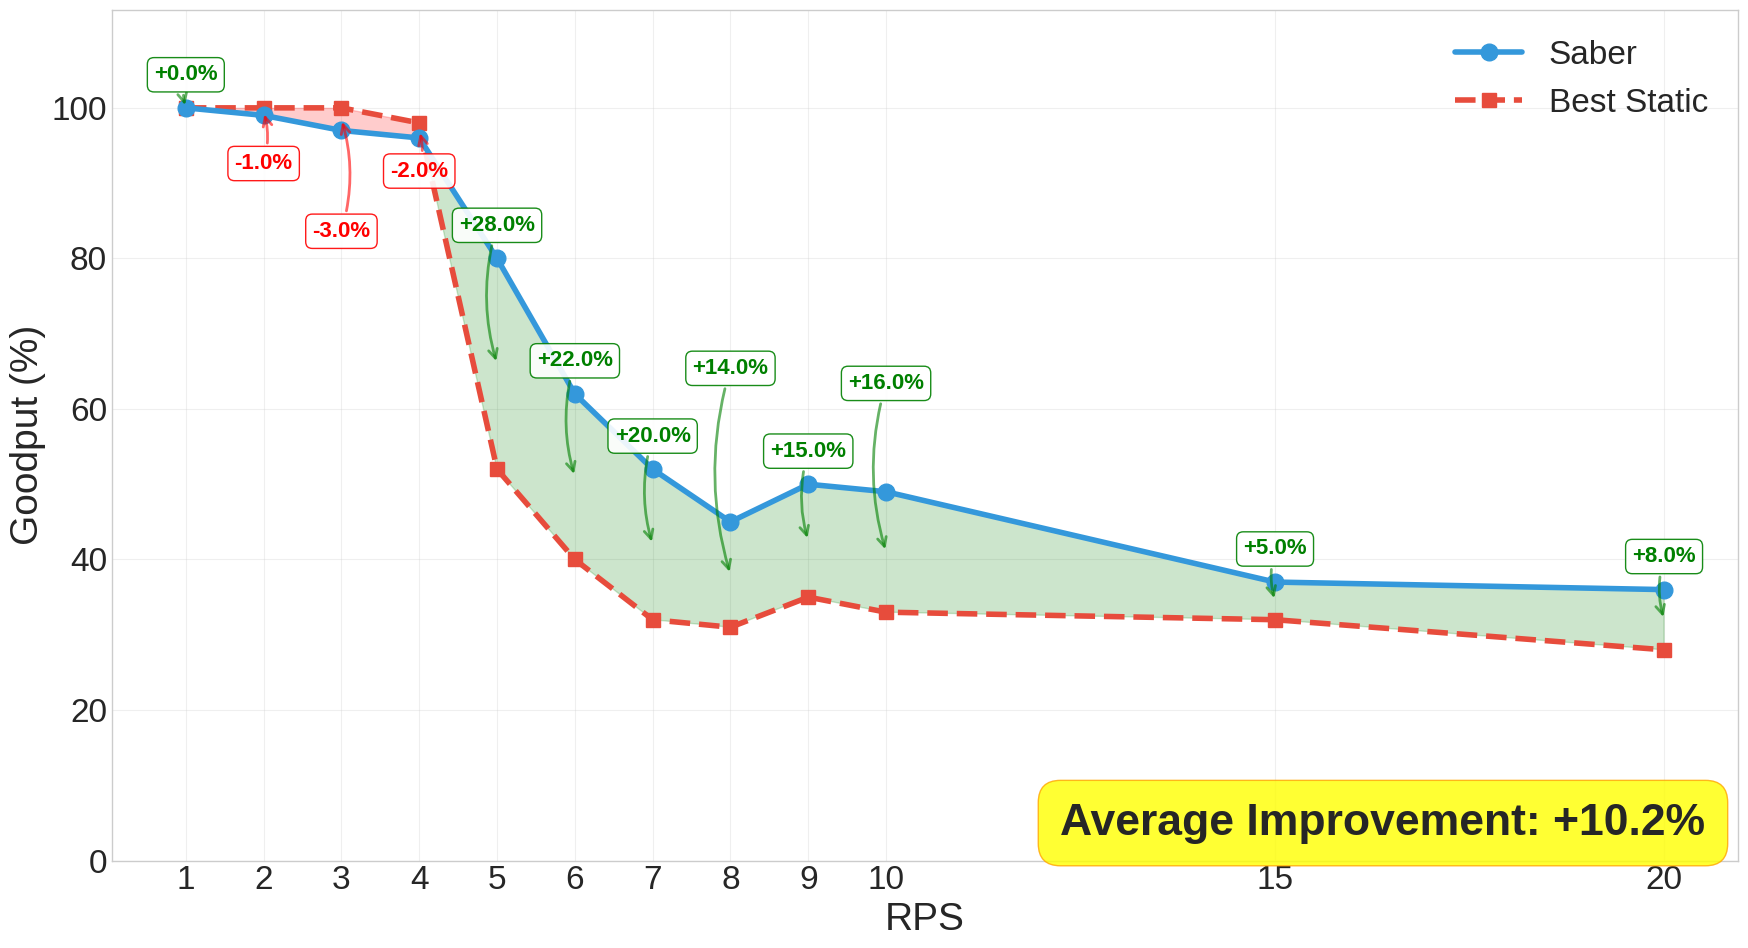


Processing workload2...
Creating SLA stability coefficient plot...
Saved: RQ2_figures/sla_stability_workload2.pdf


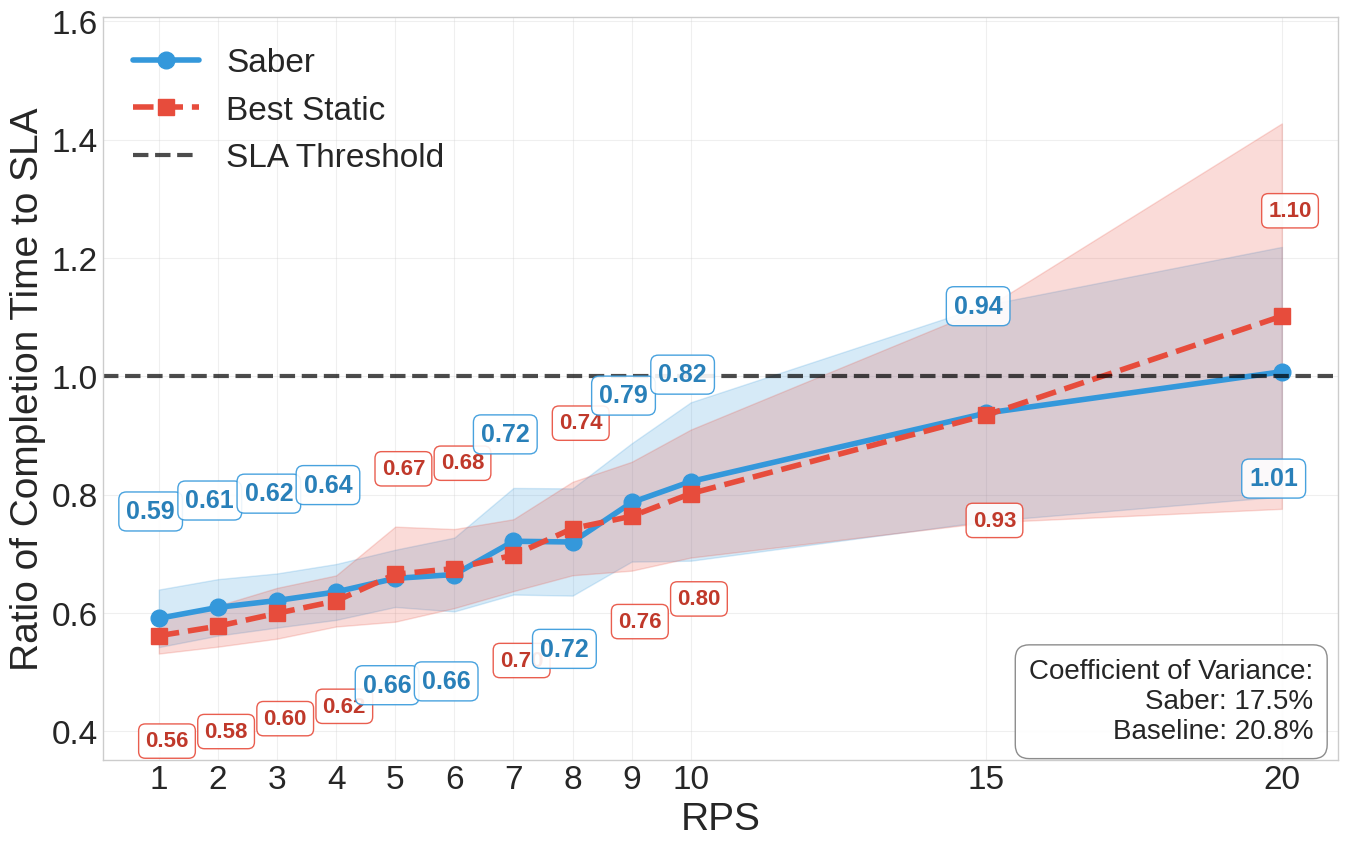

Creating goodput performance plot with annotations...
Saved: RQ2_figures/goodput_performance_workload2.pdf


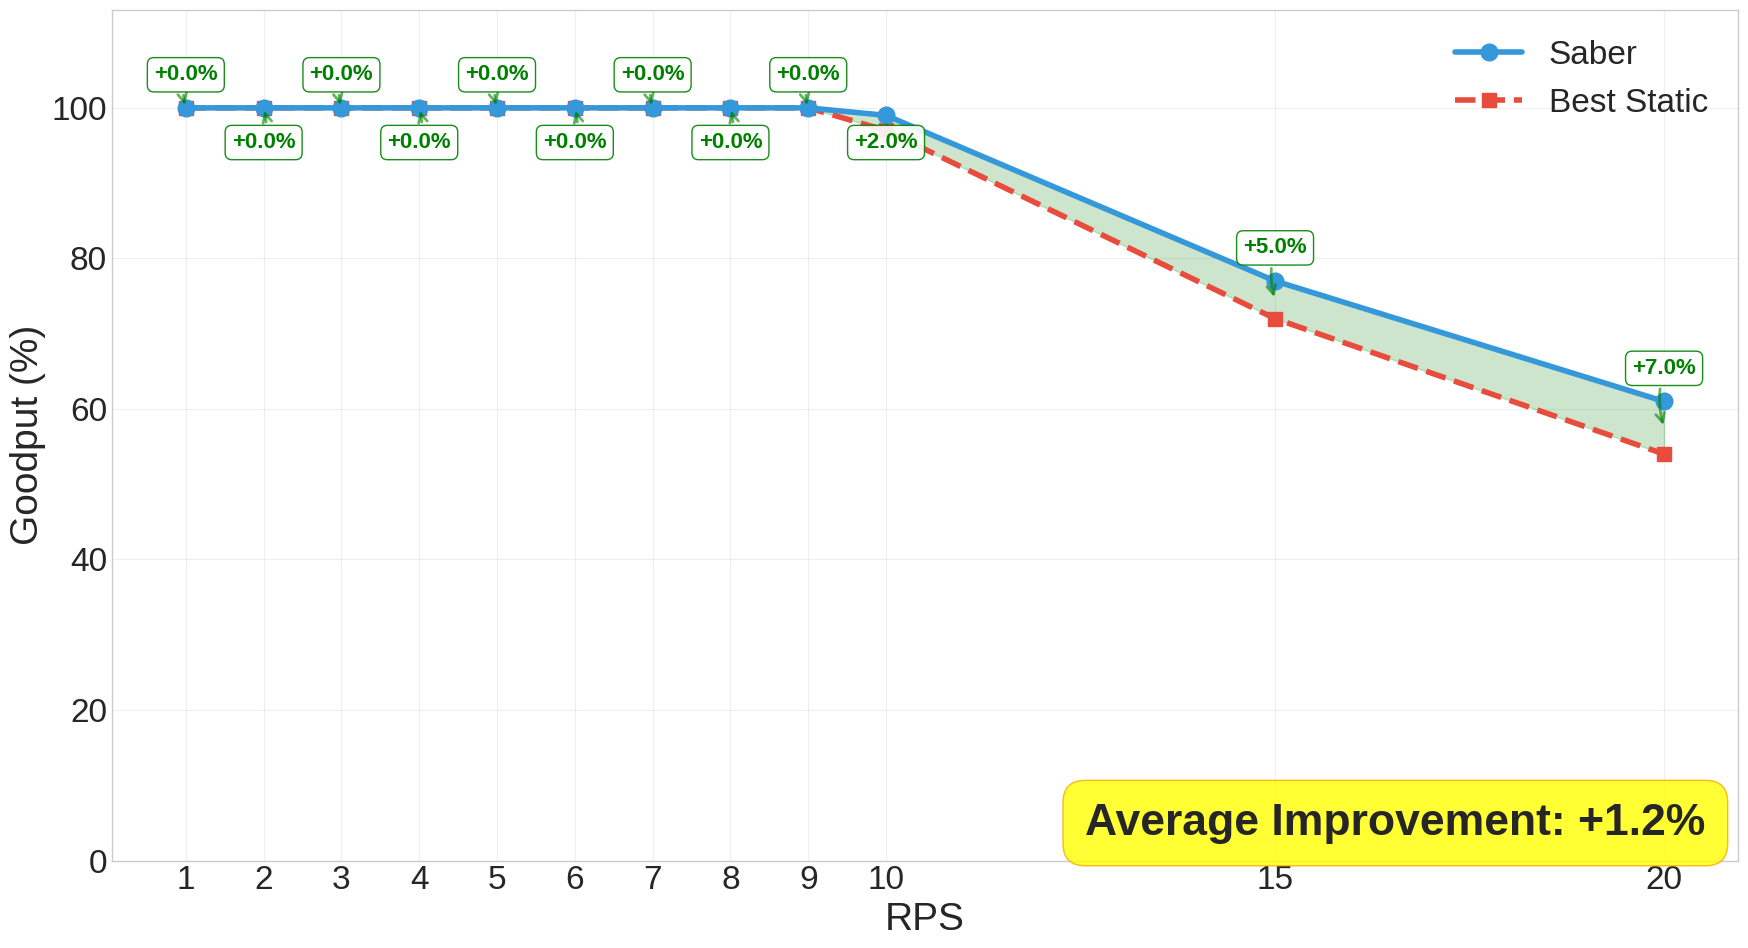


Processing workload3...
Creating SLA stability coefficient plot...
Saved: RQ2_figures/sla_stability_workload3.pdf


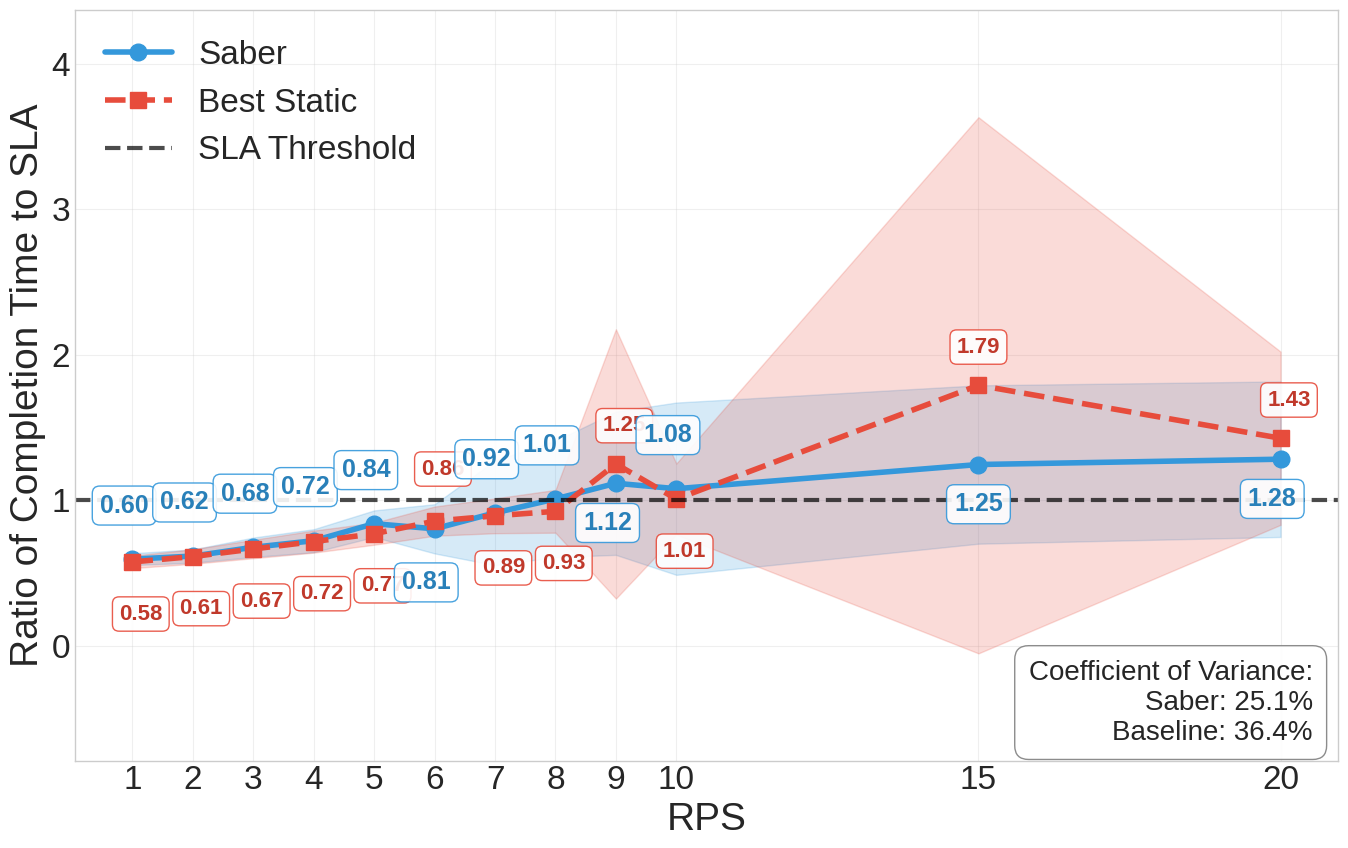

Creating goodput performance plot with annotations...
Saved: RQ2_figures/goodput_performance_workload3.pdf


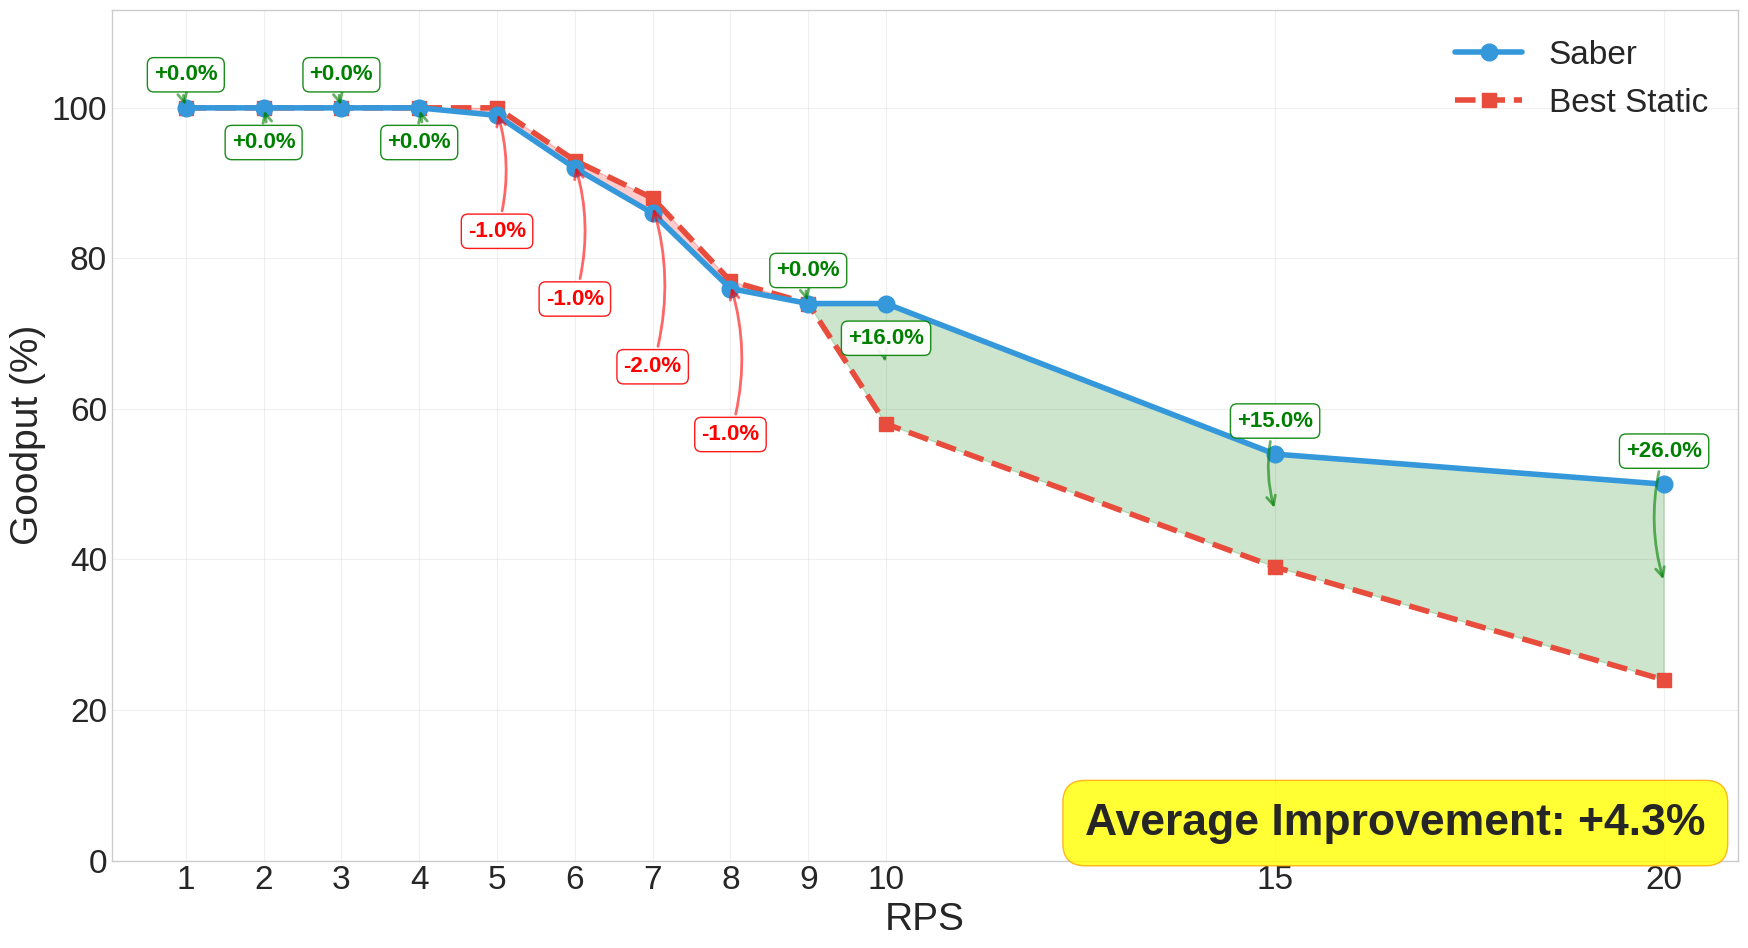


Analysis complete. All plots have been saved as PDF files.


In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')

# Global font settings
plt.rcParams['font.size'] = 24
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 32
plt.rcParams['figure.titlesize'] = 28

# ================ Global Definitions ================
task_mapping = {
    'short_input_short_output': 'CodeQnA',
    'long_input_short_output': 'CodeSummary',
    'short_input_long_output': 'CodeGen',
    'long_input_long_output': 'CodeTranslation',
    'CodeQnA': 'CodeQnA',
    'CodeSummary': 'CodeSummary',
    'CodeGen': 'CodeGen',
    'CodeTranslation': 'CodeTranslation'
}

sla_thresholds = {
    'CodeQnA': 1000,      # 1 second
    'CodeSummary': 1000,  # 1 second
    'CodeGen': 8000,      # 8 seconds
    'CodeTranslation': 12000 # 12 seconds
}

# ================ Data Loading Functions ================
def load_baseline_data(baseline_dir="baseline_experiment_results"):
    """Load baseline experimental data"""
    all_data = []
    
    if not os.path.exists(baseline_dir):
        print(f"Directory {baseline_dir} does not exist")
        return pd.DataFrame()
    
    concurrency_dirs = glob.glob(os.path.join(baseline_dir, "max_concurrency_*"))
    
    for concurrency_dir in concurrency_dirs:
        concurrency_match = re.search(r"max_concurrency_(\d+)", os.path.basename(concurrency_dir))
        if not concurrency_match:
            continue
        concurrency = int(concurrency_match.group(1))
        
        workload_dirs = glob.glob(os.path.join(concurrency_dir, "workload*"))
        for workload_dir in workload_dirs:
            workload = os.path.basename(workload_dir)
            
            csv_files = glob.glob(os.path.join(workload_dir, "*.csv"))
            for csv_file in csv_files:
                filename = os.path.basename(csv_file)
                rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
                rps = float(rps_match.group(1)) if rps_match else None
                
                df = process_file(csv_file, workload, concurrency, "baseline")
                if not df.empty:
                    df['RPS'] = rps
                    all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def load_agent_data(agent_dir="agent_data"):
    """Load adaptive agent data"""
    all_data = []
    
    if not os.path.exists(agent_dir):
        print(f"Directory {agent_dir} does not exist")
        return pd.DataFrame()
    
    csv_files = glob.glob(os.path.join(agent_dir, "*.csv"))
    
    for csv_file in csv_files:
        filename = os.path.basename(csv_file)
        workload_match = re.search(r'(workload\d+)', filename)
        if not workload_match:
            continue
        workload = workload_match.group(1)

        rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
        rps = float(rps_match.group(1)) if rps_match else None

        df = process_file(csv_file, workload, concurrency="adaptive", experiment_type="adaptive")
        if not df.empty:
            df['RPS'] = rps
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def process_file(csv_file, workload, concurrency, experiment_type):
    """Process individual CSV file"""
    try:
        df = pd.read_csv(csv_file)
        if df.empty:
            return pd.DataFrame()
        
        df.columns = [col.strip() for col in df.columns]
        
        if 'Thread ID' in df.columns:
            df = df[pd.to_numeric(df['Thread ID'], errors='coerce').notna()]
        elif 'Thread_ID' in df.columns:
            df = df[pd.to_numeric(df['Thread_ID'], errors='coerce').notna()]
        
        if 'Request Type' in df.columns:
            df = df[df['Request Type'].notna()]
        elif 'Request_Type' in df.columns:
            df = df[df['Request_Type'].notna()]
        
        column_mapping = {
            'Thread ID': 'Thread_ID',
            'Request Type': 'Request_Type',
            'Waiting Time': 'Waiting_Time',
            'Execution Time': 'Execution_Time',
            'Total Round Trip Time': 'Total_Time',
            'SLA Time': 'SLA_Time',
            'Low Priority': 'Low_Priority',
            'SLA Met': 'SLA_Met'
        }
        df = df.rename(columns=column_mapping)
        
        if 'SLA_Met' in df.columns:
            df['SLA_Met'] = df['SLA_Met'].astype(str).str.lower().map({'yes': True, 'no': False, 'true': True, 'false': False})
        
        time_columns = ['Waiting_Time', 'Execution_Time', 'Total_Time', 'SLA_Time']
        for col in time_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].notna().any() and df[col][df[col].notna()].max() < 100:
                    df.loc[df[col].notna(), col] = df.loc[df[col].notna(), col] * 1000
        
        df['Workload'] = workload
        df['Concurrency_Config'] = concurrency 
        df['Experiment_Type'] = experiment_type
        
        return df
    except Exception as e:
        print(f"Error processing file {csv_file}: {str(e)}")
        return pd.DataFrame()

def add_sla_columns(df):
    """Add SLA-related columns to dataframe"""
    df = df.copy()
    
    df['Task_Type'] = df['Request_Type'].map(task_mapping)
    if df['Task_Type'].isnull().any():
        df['Task_Type'] = df['Task_Type'].fillna('CodeQnA') 
    
    df['SLA_Threshold'] = df['Task_Type'].map(sla_thresholds)
    
    if 'SLA_Met' not in df.columns or df['SLA_Met'].isnull().all(): 
        df['SLA_Met'] = df['Total_Time'] <= df['SLA_Threshold']
    else: 
        df['SLA_Met'] = df['SLA_Met'].astype(bool)
    
    df['SLA_Utilization'] = df['Total_Time'] / df['SLA_Threshold']

    return df

# ================ Visualization Functions ================
def plot_sla_stability_coefficient(baseline_df, adaptive_df, workload, save_fig=False, output_dir="RQ2_figures"):
    """Plot SLA stability coefficient of variance"""
    
    fig, ax = plt.subplots(figsize=(14, 9))
    
    rps_values = sorted(set(baseline_df[baseline_df['Workload'] == workload]['RPS'].unique()) | 
                       set(adaptive_df[adaptive_df['Workload'] == workload]['RPS'].unique()))
    
    saber_means = []
    saber_stds = []
    baseline_means = []
    baseline_stds = []
    
    for rps in rps_values:
        # Saber data
        saber_data = adaptive_df[
            (adaptive_df['Workload'] == workload) & 
            (adaptive_df['RPS'] == rps)
        ]
        if len(saber_data) > 0:
            saber_means.append(saber_data['SLA_Utilization'].mean())
            saber_stds.append(saber_data['SLA_Utilization'].std())
        else:
            saber_means.append(np.nan)
            saber_stds.append(np.nan)
        
        # Best baseline
        best_mean = np.nan
        best_std = np.nan
        best_goodput = 0
        for conc in baseline_df['Concurrency_Config'].unique():
            if conc == 'adaptive':
                continue
            subset = baseline_df[
                (baseline_df['Workload'] == workload) & 
                (baseline_df['RPS'] == rps) & 
                (baseline_df['Concurrency_Config'] == conc)
            ]
            if len(subset) > 0:
                goodput = subset['SLA_Met'].mean()
                if goodput > best_goodput:
                    best_goodput = goodput
                    best_mean = subset['SLA_Utilization'].mean()
                    best_std = subset['SLA_Utilization'].std()
        
        baseline_means.append(best_mean)
        baseline_stds.append(best_std)
    
    # Plot lines
    ax.plot(rps_values, saber_means, 'o-', label='Saber', 
            color='#3498db', linewidth=4, markersize=12)
    ax.fill_between(rps_values, 
                   np.array(saber_means) - np.array(saber_stds),
                   np.array(saber_means) + np.array(saber_stds),
                   alpha=0.2, color='#3498db')
    
    ax.plot(rps_values, baseline_means, 's--', label='Best Static', 
            color='#e74c3c', linewidth=4, markersize=12)
    ax.fill_between(rps_values, 
                   np.array(baseline_means) - np.array(baseline_stds),
                   np.array(baseline_means) + np.array(baseline_stds),
                   alpha=0.2, color='#e74c3c')
    
    # Calculate y-axis range
    all_values = []
    for mean, std in zip(saber_means + baseline_means, saber_stds + baseline_stds):
        if not np.isnan(mean) and not np.isnan(std):
            all_values.extend([mean - std, mean + std])
    
    y_range = max(all_values) - min(all_values) if all_values else 1
    
    # Calculate RPS spacing for intelligent horizontal offset
    rps_spacing = (max(rps_values) - min(rps_values)) / (len(rps_values) - 1) if len(rps_values) > 1 else 1
    
    # Annotate data points
    for i, (rps, saber_mean, baseline_mean) in enumerate(zip(rps_values, saber_means, baseline_means)):
        # Base offset
        offset_base = 0.08 + y_range * 0.03
        
        # Check if horizontal offset needed
        need_horizontal_offset = (not np.isnan(saber_mean) and not np.isnan(baseline_mean) and 
                                abs(saber_mean - baseline_mean) < 0.15)
        
        # Annotate Saber
        if not np.isnan(saber_mean):
            if not np.isnan(baseline_mean) and saber_mean > baseline_mean:
                offset_y = offset_base
                va = 'bottom'
            else:
                offset_y = -offset_base
                va = 'top'
            
            if not np.isnan(baseline_mean) and abs(saber_mean - baseline_mean) < 0.1:
                offset_y = offset_y * 1.5
            
            x_offset = -rps_spacing * 0.08 if need_horizontal_offset else 0
            
            ax.text(rps + x_offset, saber_mean + offset_y, f'{saber_mean:.2f}', 
                   fontsize=18,
                   color='#2980b9',
                   fontweight='bold',
                   ha='center',
                   va=va,
                   bbox=dict(boxstyle="round,pad=0.3", 
                            facecolor='white', 
                            edgecolor='#3498db',
                            alpha=0.9))
        
        # Annotate Baseline
        if not np.isnan(baseline_mean):
            if not np.isnan(saber_mean) and baseline_mean > saber_mean:
                offset_y = offset_base
                va = 'bottom'
            else:
                offset_y = -offset_base
                va = 'top'
            
            if not np.isnan(saber_mean) and abs(saber_mean - baseline_mean) < 0.1:
                offset_y = offset_y * 1.5
            
            x_offset = rps_spacing * 0.08 if need_horizontal_offset else 0
            
            ax.text(rps + x_offset, baseline_mean + offset_y, f'{baseline_mean:.2f}', 
                   fontsize=16,
                   color='#c0392b',
                   fontweight='bold',
                   ha='center',
                   va=va,
                   bbox=dict(boxstyle="round,pad=0.3", 
                            facecolor='white', 
                            edgecolor='#e74c3c',
                            alpha=0.9))
    
    # SLA threshold line
    ax.axhline(y=1.0, color='black', linestyle='--', linewidth=3, alpha=0.7, label='SLA Threshold')
    
    # Calculate coefficient of variance
    if len(saber_means) > 1:
        saber_cv = np.nanstd(saber_means) / np.nanmean(saber_means) * 100
        baseline_cv = np.nanstd(baseline_means) / np.nanmean(baseline_means) * 100
        
        ax.text(0.98, 0.02, f'Coefficient of Variance:\nSaber: {saber_cv:.1f}%\nBaseline: {baseline_cv:.1f}%', 
               transform=ax.transAxes, fontsize=20, ha='right', va='bottom',
               bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='gray'))
    
    ax.set_xlabel('RPS', fontsize=28)
    ax.set_ylabel('Ratio of Completion Time to SLA', fontsize=28)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=24, framealpha=0.9)
    
    # Set x-axis
    ax.set_xticks(rps_values)
    ax.set_xticklabels([str(int(rps)) if rps.is_integer() else str(rps) for rps in rps_values], fontsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    # Dynamic y-axis range adjustment
    if all_values:
        y_min = min(all_values) - y_range * 0.2
        y_max = max(all_values) + y_range * 0.2
        ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    if save_fig:
        output_path = os.path.join(output_dir, f'sla_stability_{workload}.pdf')
        plt.savefig(output_path, format='pdf', bbox_inches='tight')
        print(f"Saved: {output_path}")
    plt.show()

def plot_goodput_performance_with_annotations(baseline_df, adaptive_df, workload, save_fig=False, output_dir="RQ2_figures"):
    """Plot goodput performance with difference annotations"""
    
    fig, ax = plt.subplots(figsize=(18, 10))
    
    rps_values = sorted(set(baseline_df[baseline_df['Workload'] == workload]['RPS'].unique()) | 
                       set(adaptive_df[adaptive_df['Workload'] == workload]['RPS'].unique()))
    
    saber_goodputs = []
    baseline_goodputs = []
    
    for rps in rps_values:
        # Saber
        saber_data = adaptive_df[
            (adaptive_df['Workload'] == workload) & 
            (adaptive_df['RPS'] == rps)
        ]
        if len(saber_data) > 0:
            saber_goodputs.append(saber_data['SLA_Met'].mean() * 100)
        else:
            saber_goodputs.append(np.nan)
        
        # Best baseline
        best_goodput = 0
        for conc in baseline_df['Concurrency_Config'].unique():
            if conc == 'adaptive':
                continue
            subset = baseline_df[
                (baseline_df['Workload'] == workload) & 
                (baseline_df['RPS'] == rps) & 
                (baseline_df['Concurrency_Config'] == conc)
            ]
            if len(subset) > 0:
                goodput = subset['SLA_Met'].mean() * 100
                best_goodput = max(best_goodput, goodput)
        
        baseline_goodputs.append(best_goodput)
    
    # Plot lines
    ax.plot(rps_values, saber_goodputs, 'o-', label='Saber', 
            color='#3498db', linewidth=4, markersize=12, zorder=3)
    ax.plot(rps_values, baseline_goodputs, 's--', label='Best Static', 
            color='#e74c3c', linewidth=4, markersize=10, zorder=2)
    
    # Fill performance gap
    ax.fill_between(rps_values, saber_goodputs, baseline_goodputs, 
                   where=(np.array(saber_goodputs) >= np.array(baseline_goodputs)), 
                   alpha=0.2, color='green', interpolate=True)
    ax.fill_between(rps_values, saber_goodputs, baseline_goodputs, 
                   where=(np.array(saber_goodputs) < np.array(baseline_goodputs)), 
                   alpha=0.2, color='red', interpolate=True)
    
    # Add difference annotations with collision detection
    annotations_info = []
    
    for i, (rps, saber, baseline) in enumerate(zip(rps_values, saber_goodputs, baseline_goodputs)):
        if not np.isnan(saber) and not np.isnan(baseline):
            diff = saber - baseline
            
            if diff >= 0:
                y_pos = max(saber, baseline) + 3
                va = 'bottom'
                color = 'green'
            else:
                y_pos = min(saber, baseline) - 3
                va = 'top'
                color = 'red'
            
            annotations_info.append({
                'rps': rps,
                'y_pos': y_pos,
                'diff': diff,
                'color': color,
                'va': va,
                'saber': saber,
                'baseline': baseline,
                'text': f'{diff:+.1f}%'
            })
    
    # Adjust positions to avoid overlaps
    annotations_info.sort(key=lambda x: x['rps'])
    
    x_range = max(rps_values) - min(rps_values)
    label_width = x_range * 0.08
    label_height = 8
    
    for i in range(len(annotations_info)):
        current = annotations_info[i]
        
        for j in range(i):
            prev = annotations_info[j]
            
            x_overlap = abs(current['rps'] - prev['rps']) < label_width
            y_overlap = abs(current['y_pos'] - prev['y_pos']) < label_height
            
            if x_overlap and y_overlap:
                if current['diff'] >= 0:
                    current['y_pos'] = prev['y_pos'] + label_height + 1
                    if current['y_pos'] > 85:
                        current['y_pos'] = prev['y_pos'] - label_height - 1
                else:
                    current['y_pos'] = prev['y_pos'] - label_height - 1
                    if current['y_pos'] < 15:
                        current['y_pos'] = prev['y_pos'] + label_height + 1
    
    # Draw annotations
    for info in annotations_info:
        ax.annotate(info['text'], 
                   xy=(info['rps'], (info['saber'] + info['baseline']) / 2),
                   xytext=(info['rps'], info['y_pos']),
                   ha='center', va=info['va'],
                   fontsize=16, fontweight='bold', color=info['color'],
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                            edgecolor=info['color'], alpha=0.9),
                   arrowprops=dict(arrowstyle='->', color=info['color'], 
                                 alpha=0.6, lw=2,
                                 connectionstyle="arc3,rad=0.15"))
    
    # Calculate and display average improvement
    differences = np.array(saber_goodputs) - np.array(baseline_goodputs)
    avg_improvement = np.nanmean(differences)
    
    ax.text(0.98, 0.02, f'Average Improvement: {avg_improvement:+.1f}%', 
            transform=ax.transAxes, fontsize=32, ha='right', va='bottom', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8, edgecolor='orange'))
    
    # Dynamic y-axis limits
    if annotations_info:
        max_annotation_y = max(info['y_pos'] for info in annotations_info)
        min_annotation_y = min(info['y_pos'] for info in annotations_info)
        
        y_max = max(105, max_annotation_y + 10)
        y_min = min(0, min_annotation_y - 10)
        ax.set_ylim(y_min, y_max)
    else:
        ax.set_ylim(0, 105)
    
    ax.set_xlabel('RPS', fontsize=28)
    ax.set_ylabel('Goodput (%)', fontsize=28)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=24, framealpha=0.9)
    
    ax.set_xticks(rps_values)
    ax.set_xticklabels([str(int(rps)) if rps.is_integer() else str(rps) for rps in rps_values], fontsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    plt.tight_layout()
    if save_fig:
        output_path = os.path.join(output_dir, f'goodput_performance_{workload}.pdf')
        plt.savefig(output_path, format='pdf', bbox_inches='tight')
        print(f"Saved: {output_path}")
    plt.show()

# ================ Main Execution ================
if __name__ == "__main__":
    # Configuration
    baseline_data_dir = "experiment_data/baseline_experiment_results"
    adaptive_data_dir = "experiment_data/saber_data_USL"
    output_dir = "RQ2_figures"
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print("Loading data...")
    baseline_df = load_baseline_data(baseline_data_dir)
    adaptive_df = load_agent_data(adaptive_data_dir)
    
    if not baseline_df.empty:
        baseline_df = add_sla_columns(baseline_df)
        print(f"Loaded {len(baseline_df)} baseline records")
    
    if not adaptive_df.empty:
        adaptive_df = add_sla_columns(adaptive_df)
        print(f"Loaded {len(adaptive_df)} adaptive records")
    
    if baseline_df.empty and adaptive_df.empty:
        print("No data found.")
        exit()
    
    print("\nGenerating RQ2 Analysis...")
    
    workloads = ['workload1', 'workload2', 'workload3']
    
    for workload in workloads:
        print(f"\nProcessing {workload}...")
        
        if (workload in baseline_df['Workload'].values or 
            workload in adaptive_df['Workload'].values):
            
            print(f"Creating SLA stability coefficient plot...")
            plot_sla_stability_coefficient(baseline_df, adaptive_df, workload, save_fig=True, output_dir=output_dir)
            
            print(f"Creating goodput performance plot with annotations...")
            plot_goodput_performance_with_annotations(baseline_df, adaptive_df, workload, save_fig=True, output_dir=output_dir)
        else:
            print(f"No data found for {workload}")
    
    print("\nAnalysis complete. All plots have been saved as PDF files.")

Loading data...
Found 10 concurrency directories in baseline


Loaded 36000 baseline records

Generating workload sensitivity analysis...


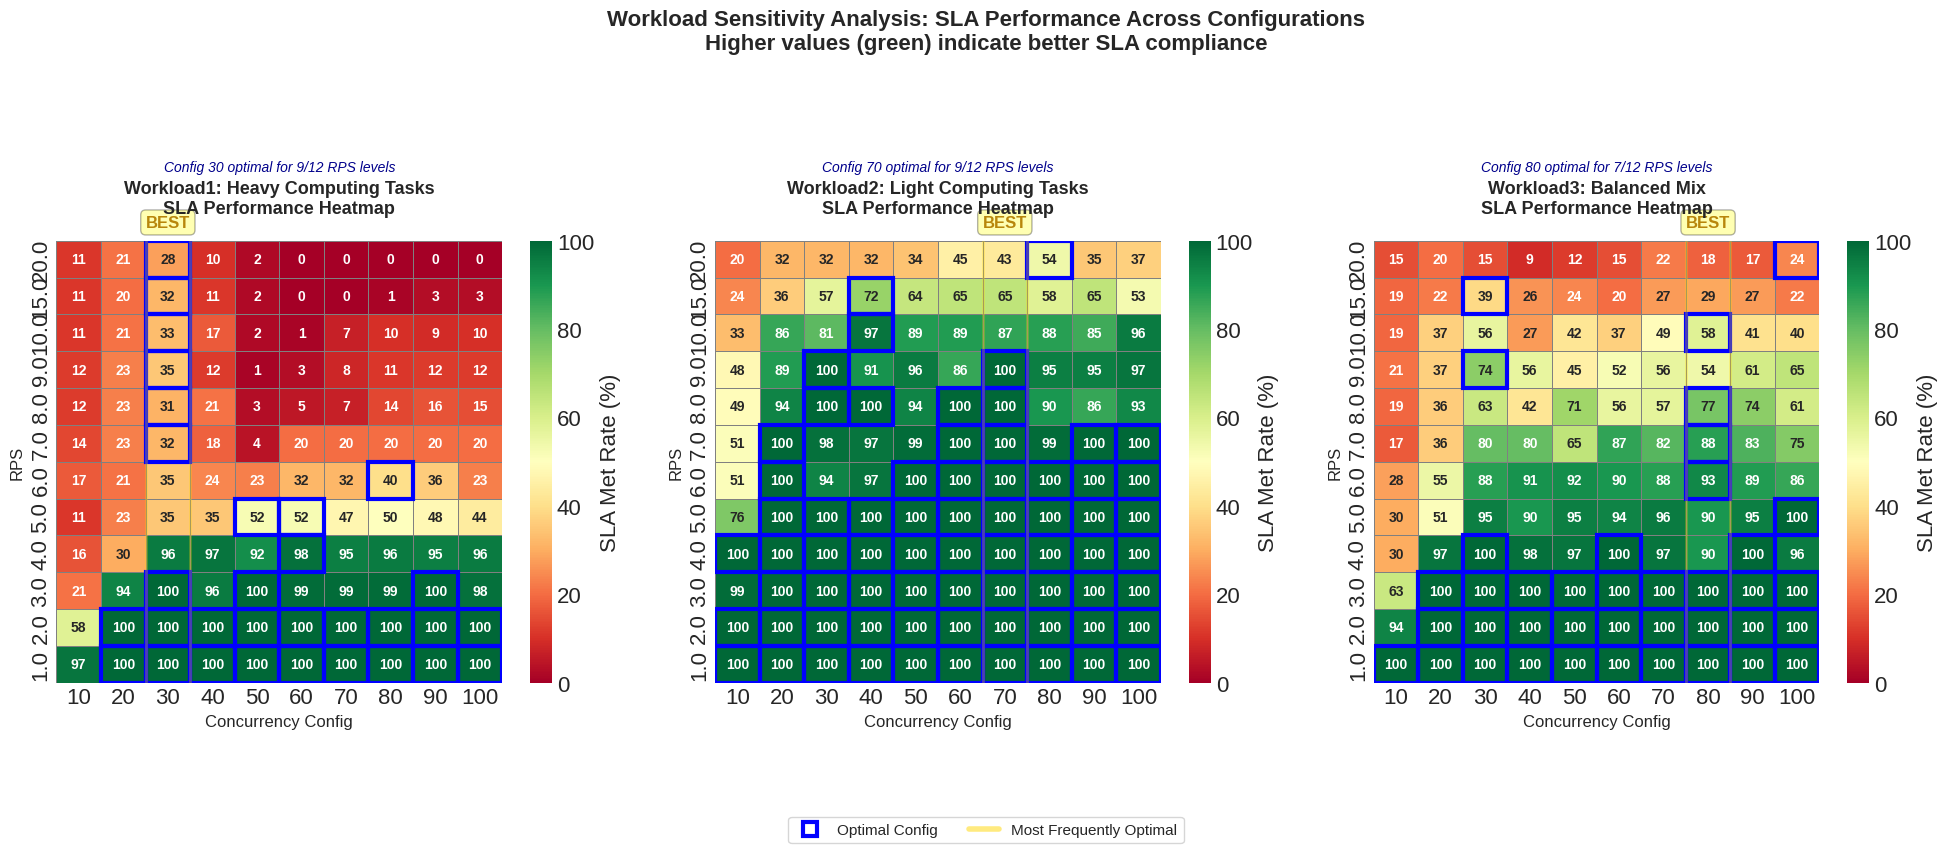


Generating alternative visualization...


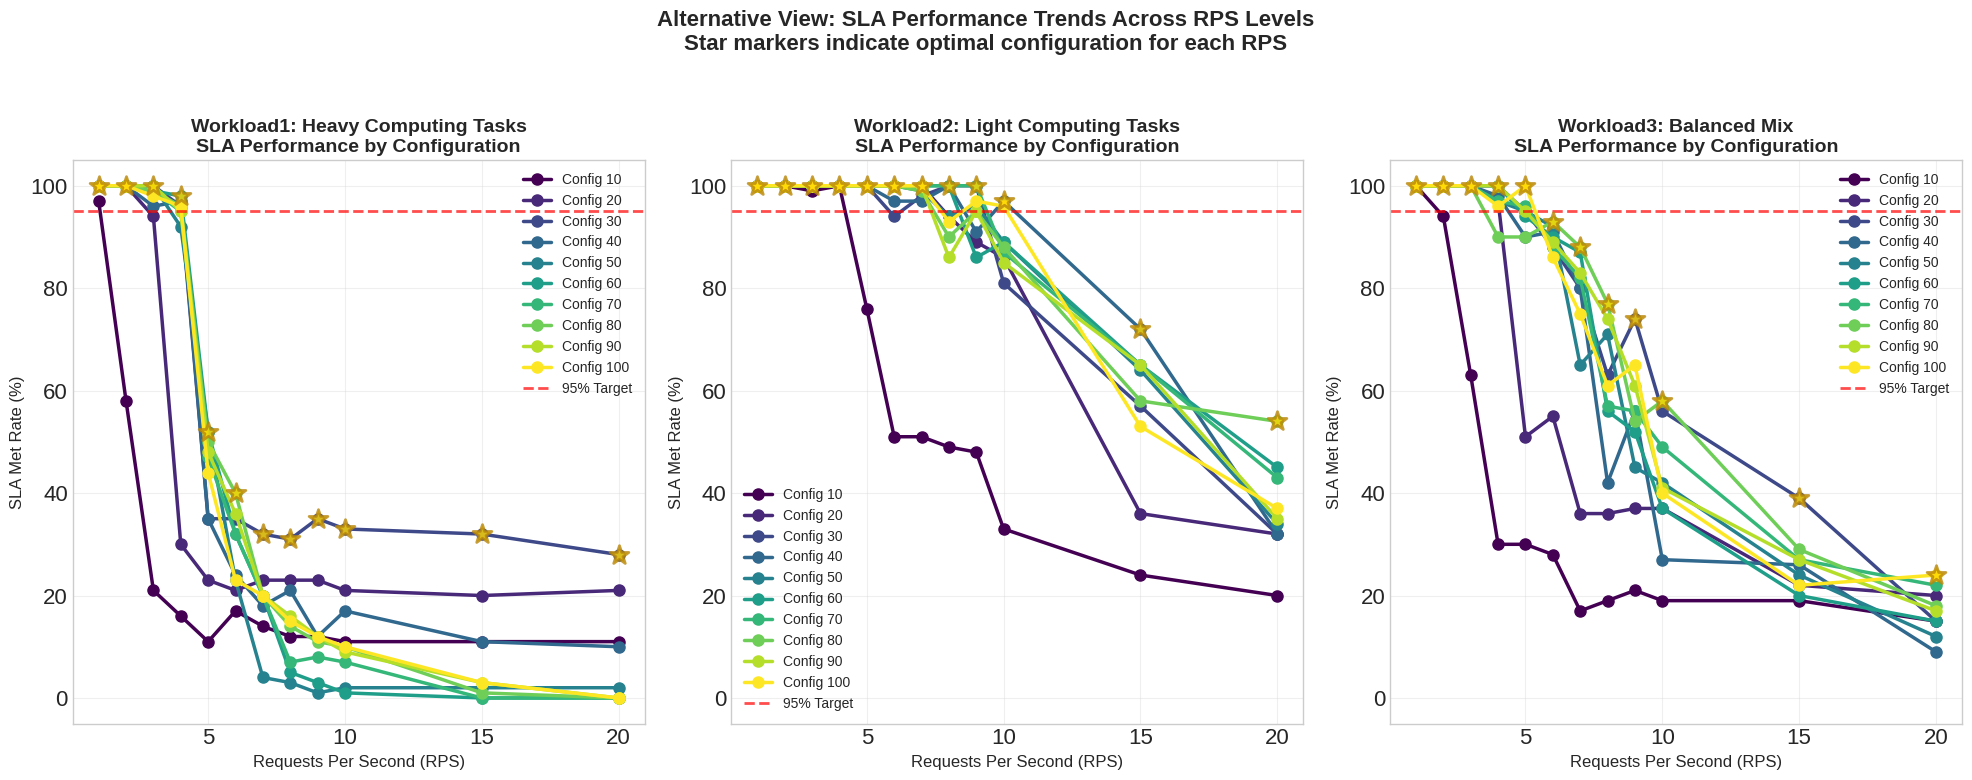


=== Key Insights ===

=== Optimal Configuration Analysis ===
Best configuration for each workload across different RPS levels:
--------------------------------------------------------------------------------

WORKLOAD1 - Heavy Computing Tasks (Long Execution Time)
  RPS 1.0: Config 20 (SLA Met: 100.0%) [Tied with: 30, 40, 50, 60, 70, 80, 90, 100]
  RPS 2.0: Config 20 (SLA Met: 100.0%) [Tied with: 30, 40, 50, 60, 70, 80, 90, 100]
  RPS 3.0: Config 30 (SLA Met: 100.0%) [Tied with: 50, 90]
  RPS 4.0: Config 60 (SLA Met: 98.0%)
  RPS 5.0: Config 50 (SLA Met: 52.0%) [Tied with: 60]
  RPS 6.0: Config 80 (SLA Met: 40.0%)
  RPS 7.0: Config 30 (SLA Met: 32.0%)
  RPS 8.0: Config 30 (SLA Met: 31.0%)
  RPS 9.0: Config 30 (SLA Met: 35.0%)
  RPS 10.0: Config 30 (SLA Met: 33.0%)
  RPS 15.0: Config 30 (SLA Met: 32.0%)
  RPS 20.0: Config 30 (SLA Met: 28.0%)

  → Recommended Config: 30 (optimal for 7/12 RPS levels)

WORKLOAD2 - Light Computing Tasks (Short Execution Time)
  RPS 1.0: Config 10 (SLA Met:

In [11]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ================ Global Definitions for SLA ================
task_mapping = {
    'short_input_short_output': 'CodeQnA',
    'long_input_short_output': 'CodeSummary',
    'short_input_long_output': 'CodeGen',
    'long_input_long_output': 'CodeTranslation',
    'CodeQnA': 'CodeQnA',
    'CodeSummary': 'CodeSummary',
    'CodeGen': 'CodeGen',
    'CodeTranslation': 'CodeTranslation'
}

sla_thresholds = {
    'CodeQnA': 1000,      # 1 second
    'CodeSummary': 1000,  # 1 second
    'CodeGen': 8000,      # 8 seconds
    'CodeTranslation': 12000 # 12 seconds
}

# ================ Data Loading Functions ================
def load_baseline_data(baseline_dir="baseline_experiment_results"):
    """Load baseline data"""
    all_data = []

    if not os.path.exists(baseline_dir):
        print(f"Warning: Directory {baseline_dir} does not exist")
        return pd.DataFrame()

    concurrency_dirs = glob.glob(os.path.join(baseline_dir, "max_concurrency_*"))
    print(f"Found {len(concurrency_dirs)} concurrency directories in baseline")

    for concurrency_dir in concurrency_dirs:
        concurrency_match = re.search(r"max_concurrency_(\d+)", os.path.basename(concurrency_dir))
        if not concurrency_match:
            print(f"Warning: Could not parse concurrency from directory {os.path.basename(concurrency_dir)}")
            continue
        concurrency = int(concurrency_match.group(1))

        workload_dirs = glob.glob(os.path.join(concurrency_dir, "workload*"))
        for workload_dir in workload_dirs:
            workload = os.path.basename(workload_dir)

            csv_files = glob.glob(os.path.join(workload_dir, "*.csv"))
            for csv_file in csv_files:
                filename = os.path.basename(csv_file)
                rps_match = re.search(r'rps_?(\d+\.?\d*)', filename)
                rps = float(rps_match.group(1)) if rps_match else None

                df = process_file(csv_file, workload, concurrency, "baseline")
                if not df.empty:
                    df['RPS'] = rps
                    all_data.append(df)

    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def process_file(csv_file, workload, concurrency, experiment_type):
    """Process a single CSV file"""
    try:
        df = pd.read_csv(csv_file)
        if df.empty:
            return pd.DataFrame()

        # Filter out summary rows - keep only rows where first column (Thread ID) is numeric
        # This removes rows like "Summary", "Expected Duration", etc.
        df = df[pd.to_numeric(df.iloc[:, 0], errors='coerce').notna()]

        if df.empty:
            return pd.DataFrame()

        df.columns = [col.strip() for col in df.columns]

        column_mapping = {
            'Thread ID': 'Thread_ID',
            'Request Type': 'Request_Type',
            'Waiting Time': 'Waiting_Time',
            'Execution Time': 'Execution_Time',
            'Total Round Trip Time': 'Total_Time',
            'SLA Time': 'SLA_Time',
            'Low Priority': 'Low_Priority',
            'SLA Met': 'SLA_Met'
        }
        df = df.rename(columns=column_mapping)

        if 'SLA_Met' in df.columns:
            df['SLA_Met'] = df['SLA_Met'].astype(str).str.lower().map({'yes': True, 'no': False, 'true': True, 'false': False})

        time_columns = ['Waiting_Time', 'Execution_Time', 'Total_Time', 'SLA_Time']
        for col in time_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].notna().any() and df[col][df[col].notna()].max() < 100:
                    df.loc[df[col].notna(), col] = df.loc[df[col].notna(), col] * 1000

        df['Workload'] = workload
        df['Concurrency_Config'] = concurrency
        df['Experiment_Type'] = experiment_type

        required_columns = ['Request_Type', 'Total_Time']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            print(f"File {os.path.basename(csv_file)} missing required columns: {missing_cols}")
            return pd.DataFrame()

        return df
    except Exception as e:
        print(f"Error processing file {csv_file}: {str(e)}")
        return pd.DataFrame()

def add_sla_columns(df):
    """Add SLA-related columns with normalization"""
    df = df.copy()

    df['Task_Type'] = df['Request_Type'].map(task_mapping)
    if df['Task_Type'].isnull().any():
        df['Task_Type'] = df['Task_Type'].fillna(df['Request_Type'].map({v: v for v in task_mapping.values()}))
        df['Task_Type'] = df['Task_Type'].fillna('CodeQnA')

    df['SLA_Threshold'] = df['Task_Type'].map(sla_thresholds)

    if 'SLA_Met' not in df.columns or df['SLA_Met'].isnull().all():
        df['SLA_Met'] = df['Total_Time'] <= df['SLA_Threshold']
    else:
        df['SLA_Met'] = df['SLA_Met'].astype(bool)

    # Add normalized columns
    df['Normalized_Waiting_Time'] = df['Waiting_Time'] / df['SLA_Threshold']
    df['Normalized_Execution_Time'] = df['Execution_Time'] / df['SLA_Threshold']
    df['Normalized_Total_Time'] = df['Total_Time'] / df['SLA_Threshold']

    return df

# ================ Analysis Functions ================

def plot_workload_sensitivity_analysis(baseline_df):
    """Show SLA performance heatmaps for different workloads"""

    # Create figure with 1x3 layout (only heatmaps)
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    workloads = ['workload1', 'workload2', 'workload3']
    workload_characteristics = {
        'workload1': 'Heavy Computing Tasks',
        'workload2': 'Light Computing Tasks',
        'workload3': 'Balanced Mix'
    }

    # Add annotations for optimal configurations
    for col_idx, workload in enumerate(workloads):
        workload_data = baseline_df[baseline_df['Workload'] == workload]

        if workload_data.empty:
            axes[col_idx].text(0.5, 0.5, 'No Data', ha='center', va='center')
            axes[col_idx].set_title(f'{workload.capitalize()}: {workload_characteristics[workload]}')
            continue

        ax = axes[col_idx]

        # Create heatmap of SLA met rate
        sla_data = workload_data.groupby(['Concurrency_Config', 'RPS'])['SLA_Met'].mean().reset_index()
        if not sla_data.empty:
            sla_pivot = sla_data.pivot(index='RPS', columns='Concurrency_Config', values='SLA_Met')
            sla_pivot = sla_pivot.sort_index(ascending=False)

            # Create custom colormap with clear boundaries
            cmap = sns.color_palette("RdYlGn", as_cmap=True)
            
            # Create the heatmap
            sns.heatmap(sla_pivot * 100, ax=ax, cmap=cmap, 
                        annot=True, fmt='.0f', 
                        cbar_kws={'label': 'SLA Met Rate (%)'},
                        vmin=0, vmax=100,
                        linewidths=0.5, linecolor='gray',
                        annot_kws={'fontsize': 10, 'weight': 'bold'})

            # Track optimal configurations
            optimal_info = []
            optimal_count = {}

            # Find optimal config for each RPS
            for i_heatmap, rps_heatmap in enumerate(sla_pivot.index):
                row_data = sla_pivot.loc[rps_heatmap]
                if not row_data.isna().all():
                    max_val = row_data.max()
                    optimal_configs = row_data[row_data == max_val].index.tolist()

                    for config_heatmap in optimal_configs:
                        col_pos = sla_pivot.columns.get_loc(config_heatmap)
                        
                        # Add blue border for optimal configs
                        rect = plt.Rectangle((col_pos, i_heatmap), 1, 1,
                                           fill=False, edgecolor='blue', lw=3)
                        ax.add_patch(rect)
                        
                        # Count optimal occurrences
                        if config_heatmap not in optimal_count:
                            optimal_count[config_heatmap] = 0
                        optimal_count[config_heatmap] += 1

            # Find the best config (most frequently optimal)
            if optimal_count:
                best_config = max(optimal_count, key=optimal_count.get)
                best_count = optimal_count[best_config]
                
                # Add text annotation for best config
                best_col_pos = sla_pivot.columns.get_loc(best_config)
                
                # Add a golden highlight for the best config column
                ax.axvline(x=best_col_pos, color='gold', linewidth=2, alpha=0.3)
                ax.axvline(x=best_col_pos + 1, color='gold', linewidth=2, alpha=0.3)
                
                # Add text below the heatmap
                ax.text(best_col_pos + 0.5, -0.7, 'BEST', 
                       ha='center', va='top', fontsize=12, 
                       color='darkgoldenrod', fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.3))
                
                # Add summary text above the heatmap with more space
                total_rps = len(sla_pivot.index)
                ax.text(0.5, 1.15, f'Config {best_config} optimal for {best_count}/{total_rps} RPS levels',
                       ha='center', va='bottom', transform=ax.transAxes,
                       fontsize=10, style='italic', color='darkblue')

        else:
            ax.text(0.5, 0.5, 'No SLA data to pivot', ha='center', va='center')

        ax.set_xlabel('Concurrency Config', fontsize=12)
        ax.set_ylabel('RPS', fontsize=12)
        ax.set_title(f'{workload.capitalize()}: {workload_characteristics[workload]}\n'
                    f'SLA Performance Heatmap', fontsize=13, fontweight='bold', pad=20)

    # Add legend outside the plots
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='none', 
                   markeredgecolor='blue', markeredgewidth=3, markersize=10, 
                   label='Optimal Config'),
        plt.Line2D([0], [0], color='gold', linewidth=4, alpha=0.5, 
                   label='Most Frequently Optimal')
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02), 
               ncol=2, fontsize=11, frameon=True)

    plt.suptitle('Workload Sensitivity Analysis: SLA Performance Across Configurations\n'
                 'Higher values (green) indicate better SLA compliance',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.05, 1, 0.94])
    plt.show()

def plot_alternative_visualization(baseline_df):
    """Alternative visualization using line plots for better trend visibility"""
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    
    workloads = ['workload1', 'workload2', 'workload3']
    workload_characteristics = {
        'workload1': 'Heavy Computing Tasks',
        'workload2': 'Light Computing Tasks',
        'workload3': 'Balanced Mix'
    }
    
    for col_idx, workload in enumerate(workloads):
        workload_data = baseline_df[baseline_df['Workload'] == workload]
        
        if workload_data.empty:
            axes[col_idx].text(0.5, 0.5, 'No Data', ha='center', va='center')
            axes[col_idx].set_title(f'{workload.capitalize()}: {workload_characteristics[workload]}')
            continue
            
        ax = axes[col_idx]
        
        # Calculate SLA met rate for each config and RPS
        sla_summary = workload_data.groupby(['Concurrency_Config', 'RPS'])['SLA_Met'].mean().reset_index()
        
        # Plot lines for each config
        configs = sorted(sla_summary['Concurrency_Config'].unique())
        colors = plt.cm.viridis(np.linspace(0, 1, len(configs)))
        
        for i, config in enumerate(configs):
            config_data = sla_summary[sla_summary['Concurrency_Config'] == config].sort_values('RPS')
            ax.plot(config_data['RPS'], config_data['SLA_Met'] * 100, 
                   marker='o', markersize=8, linewidth=2.5,
                   label=f'Config {config}', color=colors[i])
        
        # Add horizontal line at 95% SLA
        ax.axhline(y=95, color='red', linestyle='--', alpha=0.7, linewidth=2, label='95% Target')
        
        # Styling
        ax.set_xlabel('Requests Per Second (RPS)', fontsize=12)
        ax.set_ylabel('SLA Met Rate (%)', fontsize=12)
        ax.set_title(f'{workload.capitalize()}: {workload_characteristics[workload]}\n'
                    f'SLA Performance by Configuration', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.set_ylim(-5, 105)
        
        # Annotate optimal points
        rps_values = sorted(sla_summary['RPS'].unique())
        for rps in rps_values:
            rps_data = sla_summary[sla_summary['RPS'] == rps]
            if not rps_data.empty:
                max_sla = rps_data['SLA_Met'].max()
                optimal_config = rps_data[rps_data['SLA_Met'] == max_sla]['Concurrency_Config'].iloc[0]
                
                # Add a subtle marker for optimal point
                ax.scatter([rps], [max_sla * 100], s=200, marker='*', 
                          color='gold', edgecolor='darkgoldenrod', linewidth=2,
                          zorder=10, alpha=0.8)
    
    plt.suptitle('Alternative View: SLA Performance Trends Across RPS Levels\n'
                 'Star markers indicate optimal configuration for each RPS',
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ================ Main Execution ================
if __name__ == "__main__":
    # Configuration
    baseline_data_dir = "baseline_experiment_results"

    print("Loading data...")
    baseline_df = load_baseline_data(baseline_data_dir)

    if not baseline_df.empty:
        baseline_df = add_sla_columns(baseline_df)
        print(f"Loaded {len(baseline_df)} baseline records")

        # Check if required columns exist
        if 'Waiting_Time' not in baseline_df.columns or 'Execution_Time' not in baseline_df.columns:
            print("Error: Waiting_Time or Execution_Time columns not found in data!")
        elif 'Normalized_Waiting_Time' not in baseline_df.columns or 'Normalized_Execution_Time' not in baseline_df.columns:
            print("Error: Normalized time columns not found after add_sla_columns!")
        else:
            print("\nGenerating workload sensitivity analysis...")

            # Create the heatmap visualization
            plot_workload_sensitivity_analysis(baseline_df)
            
            # Also create alternative line plot visualization
            print("\nGenerating alternative visualization...")
            plot_alternative_visualization(baseline_df)

            # Print key insights
            print("\n=== Key Insights ===")
            
            # Define workload characteristics for printing
            workload_characteristics = {
                'workload1': 'Heavy Computing Tasks (Long Execution Time)',
                'workload2': 'Light Computing Tasks (Short Execution Time)',
                'workload3': 'Balanced Mix of Heavy and Light Tasks'
            }
            
            # Print optimal configuration analysis
            print("\n=== Optimal Configuration Analysis ===")
            print("Best configuration for each workload across different RPS levels:")
            print("-" * 80)
            
            for workload in ['workload1', 'workload2', 'workload3']:
                workload_data = baseline_df[baseline_df['Workload'] == workload]
                if workload_data.empty:
                    print(f"\n{workload.upper()}: No data available")
                    continue
                
                print(f"\n{workload.upper()} - {workload_characteristics[workload]}")
                
                # Find optimal config for each RPS
                sla_summary = workload_data.groupby(['RPS', 'Concurrency_Config'])['SLA_Met'].mean().reset_index()
                
                for rps in sorted(sla_summary['RPS'].unique()):
                    rps_data = sla_summary[sla_summary['RPS'] == rps]
                    if not rps_data.empty:
                        max_sla = rps_data['SLA_Met'].max()
                        optimal_configs = rps_data[rps_data['SLA_Met'] == max_sla]['Concurrency_Config'].tolist()
                        
                        print(f"  RPS {rps:>3}: Config {optimal_configs[0]:>2} "
                              f"(SLA Met: {max_sla*100:.1f}%)", end="")
                        if len(optimal_configs) > 1:
                            print(f" [Tied with: {', '.join(map(str, optimal_configs[1:]))}]")
                        else:
                            print()
                
                # Find overall best config
                config_wins = workload_data.groupby(['RPS', 'Concurrency_Config'])['SLA_Met'].mean().reset_index()
                optimal_counts = {}
                
                for rps in config_wins['RPS'].unique():
                    rps_data = config_wins[config_wins['RPS'] == rps]
                    max_sla = rps_data['SLA_Met'].max()
                    optimal_config = rps_data[rps_data['SLA_Met'] == max_sla]['Concurrency_Config'].iloc[0]
                    optimal_counts[optimal_config] = optimal_counts.get(optimal_config, 0) + 1
                
                if optimal_counts:
                    best_config = max(optimal_counts, key=optimal_counts.get)
                    print(f"\n  → Recommended Config: {best_config} "
                          f"(optimal for {optimal_counts[best_config]}/{len(config_wins['RPS'].unique())} RPS levels)")
            
            print("\n" + "="*80)
            print("Visualization Guide:")
            print("- Heatmap: Green = High SLA compliance, Red = Low SLA compliance")
            print("- Blue borders: Optimal configuration for that RPS level")
            print("- BEST label: Configuration that's optimal for most RPS levels")
            print("- Line plot: Shows trends and makes it easier to compare configurations")
            print("="*80)
    else:
        print("No baseline data loaded!")

    print("\nAnalysis complete!")